# Lake tables - EFAS6
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 04-03-2025<br>

**Introduction:**<br>
This notebook extracts the attributes required by LISFLOOD for the lakes selected to be modelled in EFAS6:

* Lake area
* Outlet width
* Average inflow

**To do:**
* [ ] Why are there 240 lakes in the EFAS5 attribute tables, but only 203 in the map?
* [ ] There are 4 cases in the selection of lakes for EFAS6 that are actually a controlled lake with an assigned GRanD ID. Check the degree of regulation for final check whether these lakes should be modelled as lakes or reservoirs.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path
import yaml
from scipy.optimize import curve_fit
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.utils import outlet_width
from lisfloodreservoirs.utils.plots import plot_reservoir_map, compare_attributes
from lisfloodreservoirs.utils.ncextract import extract_timeseries

In [2]:
def width_from_area(area: float, c: float) -> float:
    """Estimation of the river width based on catchment area:
            width = area**c
    
    Parameters:
    -----------
    area: float
        catchment area in km2
    c: float
        coefficient of the model
        
    Returns:
    --------
    width: float
        river width in meters
    """
    return area**c

## Configuration

In [3]:
# paths
PATH_EFAS5 = Path('Z:/nahaUsers/casadje/EFASv5')
PATH_EFAS6 = Path('Z:/nahaUsers/casadje/EFASv6')
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')
PATH_GLWD = PATH_DATASETS / 'lakes' / 'GLWD'
PATH_HYLAK = PATH_DATASETS / 'lakes' / 'HydroLAKES' / 'LakeATLAS_v10_shp'
PATH_OUT = PATH_EFAS6 / 'lakes' / 'tables'
PATH_OUT.mkdir(parents=True, exist_ok=True)

# # minimum storage capacity included in EFAS
MIN_VOLUME = 10 # hm³
MIN_AREA = 5 # km²
MIN_CATCHMENT = 50 # km²
# MIN_DOR = 30 # days

## DATA

### EFAS5

#### Lakes

In [4]:
# load EFAS5 lakes
efas5 = gpd.read_file(PATH_EFAS5 / 'tables' / 'EFAS5_lakes.shp').set_index('LakID', drop=True)
efas5.index.name = 'LAK_ID'

# add attributes from the tables
if 'efas_attrs' in locals():
    del efas_attrs
prefix = 'lake'
for file in (PATH_EFAS5 / 'tables').glob(f'{prefix}*.txt'):
    var = file.stem.removeprefix(prefix)
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['LAK_ID', var]
        df.set_index('LAK_ID', inplace=True, drop=True)
        efas5[var] = df
    except:
        print(file)
        continue
# convert area to km2
efas5['area'] /= 1e6
efas5.rename(columns={'a': 'alpha'}, inplace=True)
efas5.drop(['AREA_KM2', 'LON_ORG', 'LAT_ORG', 'LISFLOODX', 'LISFLOODY'], axis=1, inplace=True)

In [5]:
efas5.SOURCE.value_counts()

GLWD1         144
GLWD2          50
GranD           7
Burek_Lake      1
GLOFAS-R        1
Name: SOURCE, dtype: int64

#### Static_maps

In [6]:
# upstream area
uparea = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'upArea_European_01min.nc').squeeze(dim='band')

# channel width
chanbw = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'chanbw_European_01min.nc').squeeze(dim='band')
chanbw = chanbw.where(chanbw >= 0, np.nan)

# local drainage direction map
ldd = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'ldd_European_01min.nc').squeeze(dim='band')

### EFAS6
#### Lakes

In [7]:
# import shapefile
efas6 = gpd.read_file(PATH_EFAS6 / 'lakes' / 'LakesEfasV6.shp')

# keep only selected lakes
efas6 = efas6[efas6.checked != 3]

# select columns
id_cols = ['LakID', 'GLWD_ID', 'Hylak_id']
efas6 = efas6[id_cols + ['geometry']]
efas6[id_cols] = efas6[id_cols].replace(0, np.nan)
for col in id_cols:
    efas6[col] = efas6[col].astype('Int64')
efas6.rename(columns={'LakID': 'LAK_ID', 'Hylak_id': 'HYLAK_ID'}, inplace=True)
    
# correct HydroLakes IDs
with open('lakes_EFAS5_HydroLakes.yaml', 'r') as file:
    map_efas_hylak = yaml.safe_load(file)
correct_hylak_ids = efas6.LAK_ID.map(map_efas_hylak).astype('Int64').dropna()
efas6.loc[correct_hylak_ids.index, 'HYLAK_ID'] = correct_hylak_ids.values

# add GLWD IDs
with open('lakes_EFAS5_GLWD.yaml', 'r') as file:
    map_efas_glwd = yaml.safe_load(file)
correct_glwd_ids = efas6.LAK_ID.map(map_efas_glwd).astype('Int64').dropna()
efas6.loc[correct_glwd_ids.index, 'GLWD_ID'] = correct_glwd_ids.values

efas6.sort_values(['HYLAK_ID'], ascending=True, inplace=True)
efas6.reset_index(drop=True, inplace=True)
efas6.index.name = 'FID'
print('{0} lakes in EFAS6'.format(efas6.shape[0]))
print('\t* {0} were in EFAS5'.format(efas6.LAK_ID.notnull().sum()))
print('\t* {0} are in HydroLakes'.format(efas6.HYLAK_ID.notnull().sum()))
print('\t* {0} are in GLWD'.format(efas6.GLWD_ID.notnull().sum()))

214 lakes in EFAS6
	* 120 were in EFAS5
	* 214 are in HydroLakes
	* 119 are in GLWD


In [8]:
# points of interest used to extract values from maps
poi6 = pd.concat((efas6.geometry.x, efas6.geometry.y), axis=1)
poi6.columns = ['x', 'y']
poi6 = poi6.to_xarray()

In [9]:
# points = pd.concat((efas6.geometry.x, efas6.geometry.y), axis=1)
# points.columns = ['lon', 'lat']
# points.index.name = 'ID'

# points.to_csv(PATH_EFAS6 / 'ncextract' / f'lakes_efas6_{efas6.shape[0]}.csv')

#### Reservoirs with low degree of regulation

In [10]:
reservoirs = pd.read_excel(
    # PATH_EFAS6 / 'reservoirs' / 'tables' / 'efas6_reservoirs.xlsx',
    list((PATH_EFAS6 / 'reservoirs' / 'tables').glob('efas6_reservoirs_*.xlsx'))[-1],
    sheet_name='as_lakes',
)
reservoirs.set_index('GDW_ID', drop=False, inplace=True)
id_cols = ['GDW_ID', 'RES_ID', 'GRAND_ID', 'HYLAK_ID']
reservoirs[id_cols] = reservoirs[id_cols].astype('Int64')

print(reservoirs.shape)
# reservoirs.head(1)

(183, 27)


### GLWD

In [11]:
# level 1
glwd1 = gpd.read_file(PATH_GLWD / 'level1' / 'glwd_1.shp').set_index('GLWD_ID', drop=True)
glwd1 = glwd1.loc[glwd1.index.intersection(efas6.GLWD_ID)]

# level 2
glwd2 = gpd.read_file(PATH_GLWD / 'level2' / 'glwd_2.shp').set_index('GLWD_ID', drop=True)
glwd2 = glwd2.loc[glwd2.index.intersection(efas6.GLWD_ID)]

# concatenate
glwd = pd.concat((glwd1, glwd2), axis=0)

if not glwd.shape[0] == efas6.GLWD_ID.notnull().sum():
    print('The number of lakes in "glwd" does not match the number of lakes in "efas6" with assigned GLWD_ID')

### HydroLakes

In [12]:
hylak = gpd.read_file(PATH_EFAS6 / 'lakes' / 'hydrolakes_domain.shp')
hylak.rename(columns={'Hylak_id': 'HYLAK_ID', 'Grand_id': 'GRAND_ID'}, inplace=True)
hylak.set_index('HYLAK_ID', drop=True, inplace=True)
hylak = hylak.loc[hylak.index.intersection(efas6.HYLAK_ID)]
hylak.GRAND_ID = hylak.GRAND_ID.replace(0, np.nan).astype('Int64')

if not hylak.shape[0] == efas6.HYLAK_ID.nunique():
    print('The number of lakes in "hylak" ({0}) does not match the number of lakes in "efas6" with assigned HYLAK_ID ({1})'.format(hylak.shape[0], efas6.HYLAK_ID.nunique()))

In [13]:
hylak.Lake_type.value_counts()

1    207
3      4
Name: Lake_type, dtype: int64

There are 4 lakes in the selection which are considered as controlled lakes by HydroLakes, therefore, they have a `GRAND_ID` that I will add to the `efas6` table.

In [14]:
# add GRAND_ID to lakes in EFAS6
efas6['GRAND_ID'] = efas6.HYLAK_ID.map(hylak.GRAND_ID)

## Attributes

### Catchment area

In [15]:
catchment = pd.DataFrame(index=efas6.index, columns=['UPAREA', 'GLWD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
catchment.SOURCE = catchment.SOURCE.astype(str)

# upstream area map
# for ID, point in efas6.geometry.items():
#     catchment.loc[ID, 'UPAREA'] = uparea.sel(x=point.x, y=point.y, method='nearest').item() * 1e-6
catchment['UPAREA'] = np.round(uparea.sel({'x': poi6['x'], 'y': poi6['y']}, method='nearest') * 1e-6, 0).to_pandas()

# GLWD
idx = efas6[efas6.GLWD_ID.notnull()].GLWD_ID
catchment.loc[idx.index, 'GLWD'] = glwd.loc[idx.values, 'CATCH_TSKM'].values * 1e3

# HydroLakes
idx = efas6[efas6.HYLAK_ID.isin(hylak.index)].HYLAK_ID
catchment.loc[idx.index, 'HYLAK'] = hylak.loc[idx.values, 'Wshd_area'].values

#### Comparison

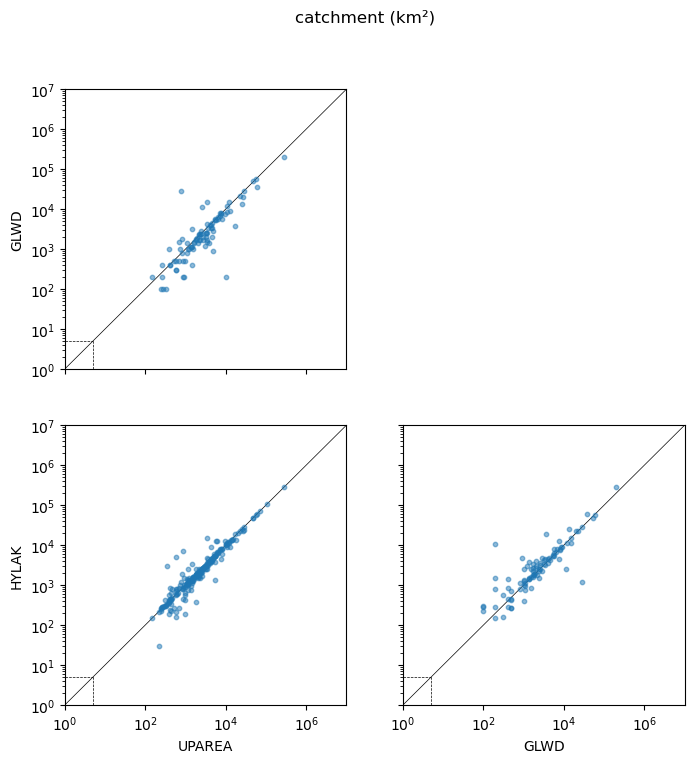

In [16]:
compare_attributes(
    catchment[['UPAREA', 'GLWD', 'HYLAK']],
    thr=MIN_AREA,
    vmin=1,
    vmax=1e7,
    title='catchment (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'catchment_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

In [17]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['HYLAK', 'GLWD', 'UPAREA']:
    missing = catchment.EFAS6.isnull()
    mask = catchment[source].notnull()
    catchment.loc[missing & mask, 'EFAS6'] = catchment.loc[missing & mask, source]
    catchment.loc[missing & mask, 'SOURCE'] = source
print('{0} reservoirs are missing the catchment value'.format(catchment.EFAS6.isnull().sum()))
print('{0} reservoirs have nevative catchment value'.format((catchment.EFAS6 < 0).sum()))
catchment.SOURCE.value_counts()

0 reservoirs are missing the catchment value
0 reservoirs have nevative catchment value


HYLAK    214
Name: SOURCE, dtype: int64

0 reservoirs do not comply with the minimum catchment area of 50 km²


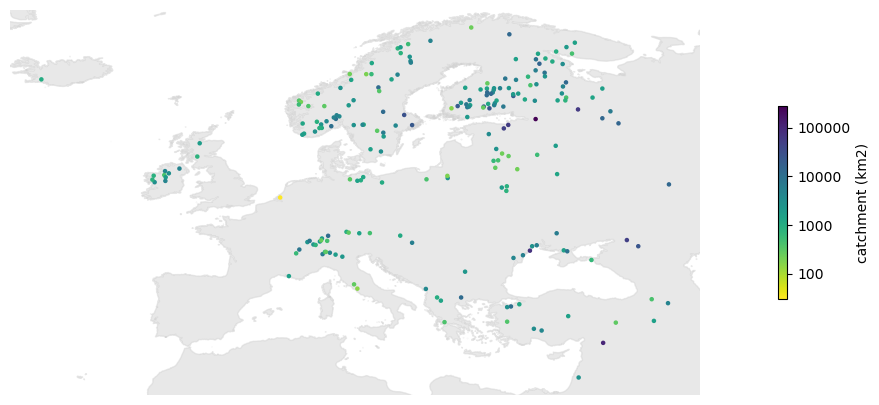

In [18]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=np.log10(catchment.EFAS6),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='catchment (km2)')
ticks = [2, 3, 4, 5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'catchment_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[catchment.index, ['CATCH_SKM', 'CATCH_SRC']] = catchment[['EFAS6', 'SOURCE']].values
print('{0} reservoirs do not comply with the minimum catchment area of {1} km²'.format((efas6.CATCH_SKM < MIN_AREA).sum(),
                                                                                       MIN_CATCHMENT))

### Lake area

In [19]:
area = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'GLWD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
area.SOURCE = area.SOURCE.astype(str)

# EFAS5
idx = efas6[efas6.LAK_ID.notnull()].LAK_ID
area.loc[idx.index, 'EFAS5'] = efas5.loc[idx.values, 'area'].values

# GLWD
idx = efas6[efas6.GLWD_ID.notnull()].GLWD_ID
area.loc[idx.index, 'GLWD'] = glwd.loc[idx.values, 'AREA_SKM'].values

# HydroLakes
idx = efas6[efas6.HYLAK_ID.isin(hylak.index)].HYLAK_ID
# idx = efas6[efas6.HYLAK_ID.notnull()].HYLAK_ID
area.loc[idx.index, 'HYLAK'] = hylak.loc[idx.values, 'Lake_area'].values

#### Comparison

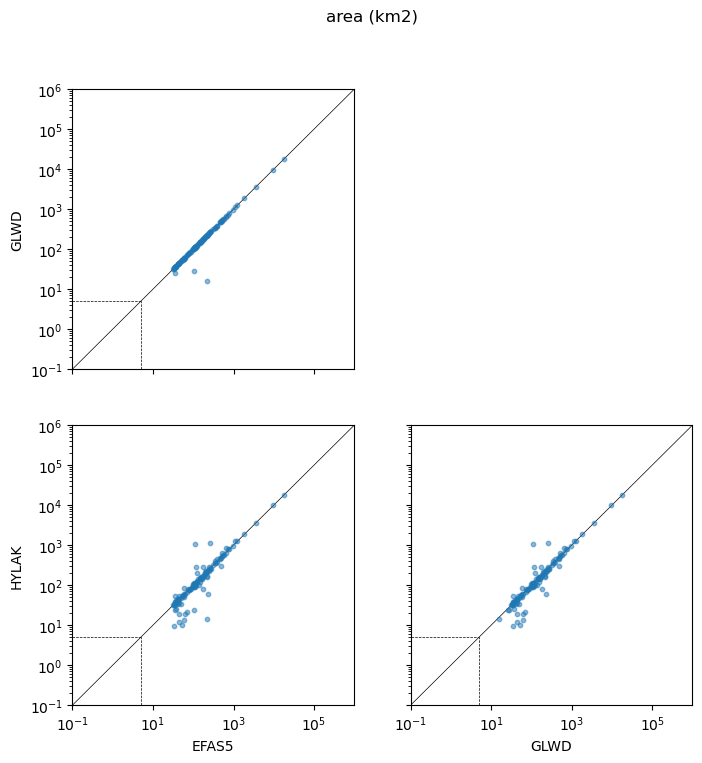

In [20]:
compare_attributes(
    area[['EFAS5', 'GLWD', 'HYLAK']],
    thr=MIN_AREA,
    vmin=1e-1,
    vmax=1e6,
    title='area (km2)'
)
plt.savefig(PATH_OUT / 'plots' / 'area_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values

Some `HYLAK_ID` are repeated in EFAS6 because HydroLakes considers as a single lake cases where GLWD (and therefore EFAS5) considers several lakes. Therefore, using the HYLAK value will overestimate total area. I will use as main source GLWD, then EFAS5 and lastly HYLAK.

In [21]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
area.EFAS6 = np.nan
for source in ['GLWD', 'EFAS5', 'HYLAK']:
    missing = area.EFAS6.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'EFAS6'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source
print('{0} reservoirs are missing the area value'.format(area.EFAS6.isnull().sum()))
print('{0} reservoirs have nevative area value'.format((area.EFAS6 < 0).sum()))
area.SOURCE.value_counts()

0 reservoirs are missing the area value
0 reservoirs have nevative area value


GLWD     119
HYLAK     94
EFAS5      1
Name: SOURCE, dtype: int64

0 lakes do not comply with the minimum lake area of 5 km2


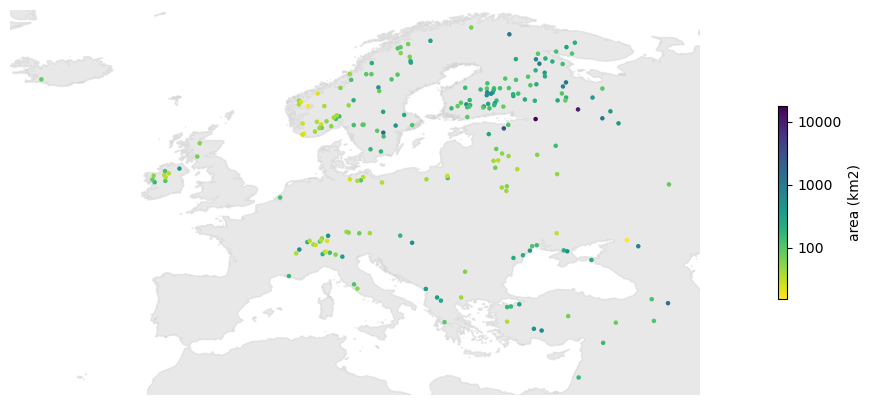

In [22]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=np.log10(area.EFAS6),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='area (km2)')
ticks = [2, 3, 4]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'area_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[area.index, ['AREA_SKM', 'AREA_SRC']] = area[['EFAS6', 'SOURCE']].values

print('{0} lakes do not comply with the minimum lake area of {1} km2'.format((efas6.AREA_SKM < MIN_AREA).sum(),
                                                                             MIN_AREA))

### $\alpha$: width of the outlet

In [23]:
alpha = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'BUREK', 'EXP', 'CHANBW', 'EFAS6', 'SOURCE'], dtype=float)
alpha.SOURCE = alpha.SOURCE.astype(str)

# EFAS5
idx = efas6[efas6.LAK_ID.notnull()].LAK_ID
alpha.loc[idx.index, 'EFAS5'] = efas5.loc[idx.values, 'alpha'].values

# using Burek's formula
alpha['BUREK'] = catchment.UPAREA * 0.0032

# fit a exponential function to the EFAS5 data
aux = efas5[efas5.alpha != efas5.alpha.min()]
params, covariance = curve_fit(width_from_area, aux.CATCH_AREA, aux.alpha, p0=[.5])
print('c = {0:.2f}'.format(params[0]))
alpha['EXP'] = width_from_area(efas6.CATCH_SKM, c=params[0])

# channel width
for ID, point in efas6.geometry.items():
    alpha.loc[ID, 'CHANBW'] = outlet_width(chanbw, uparea, point.x, point.y, n_points=3)

c = 0.55
Failed to find downstream pixel: numpy.nanmax raises on a.size==0 and axis=None; So Bottleneck too.
Failed to find downstream pixel: numpy.nanmax raises on a.size==0 and axis=None; So Bottleneck too.
Failed to find downstream pixel: numpy.nanmax raises on a.size==0 and axis=None; So Bottleneck too.


#### Comparison 

In [24]:
# fig, axes = plt.subplots(ncols=3, figsize=(10, 3), sharex=True, sharey=True)

# vmin, vmax = .01, 1000
# for ax, col in zip(axes, ['CHANBW', 'BUREK', 'EXP']):
#     ax.scatter(alpha[col], alpha.EFAS5, s=8, alpha=.5)
#     ax.plot([vmin, vmax], [vmin, vmax], 'k', lw=.5, zorder=0)
#     ax.set(
#         xlabel=col,
#         xscale='log',
#         yscale='log'
#     )
#     if ax == axes[0]:
#         ax.set_ylabel('EFAS5')
#         ax.set(
#             xlim=(vmin, vmax),
#             ylim=(vmin, vmax)
#         )

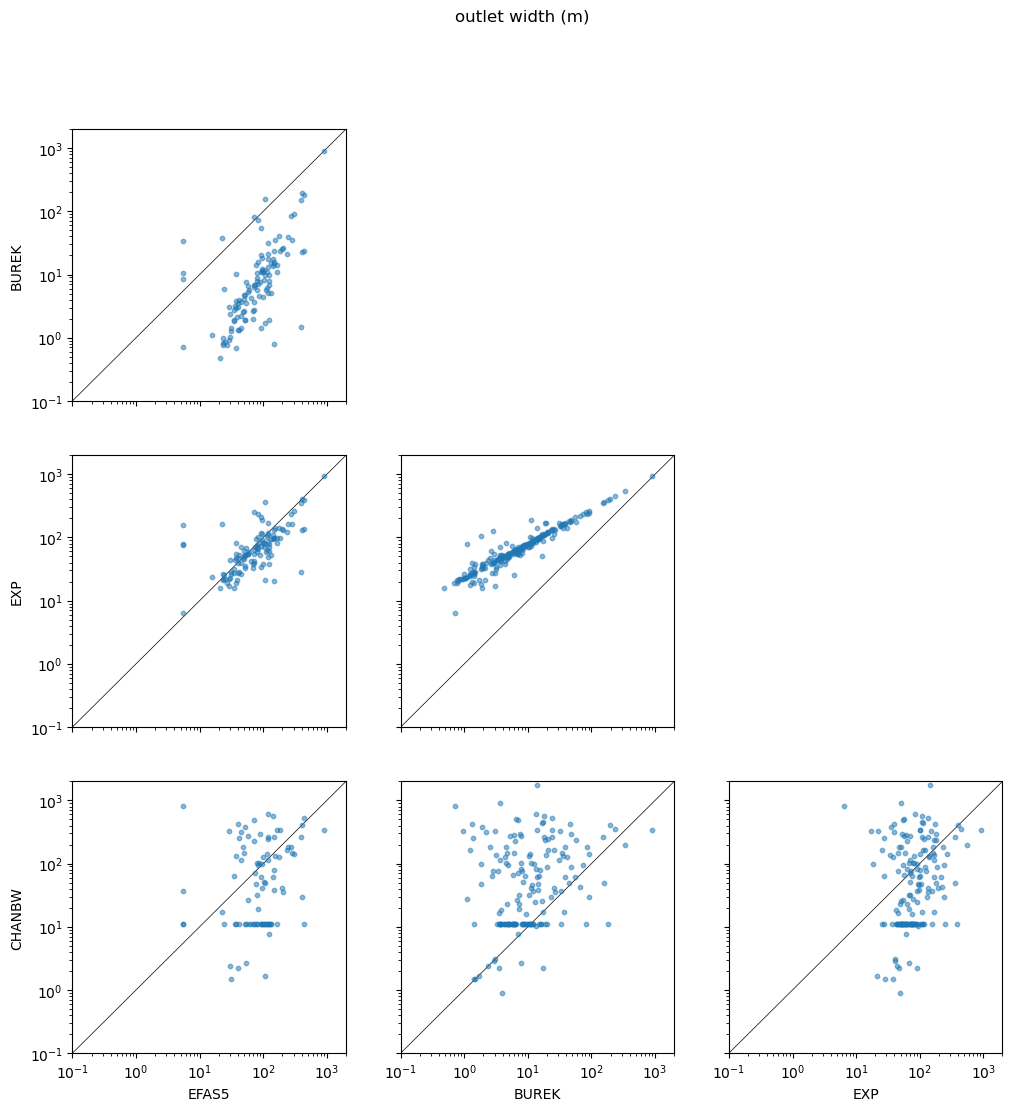

In [25]:
compare_attributes(
    alpha[['EFAS5', 'BUREK', 'EXP', 'CHANBW']],
    thr=0,
    vmin=.1,
    vmax=2000,
    title='outlet width (m)'
)
plt.savefig(PATH_OUT / 'plots' / 'outlet_width_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values
I select EFAS5 values, if possible. If not, I will use the exponential function.

In [26]:
# select value from GRAND, EFAS5, HYLAK or ICOLD in that order
for source in ['EFAS5', 'EXP']:
    missing = alpha.EFAS6.isnull()
    mask = alpha[source].notnull()
    alpha.loc[missing & mask, 'EFAS6'] = alpha.loc[missing & mask, source]
    alpha.loc[missing & mask, 'SOURCE'] = source
print('{0} reservoirs are missing the outlet width'.format(alpha.EFAS6.isnull().sum()))
print('{0} reservoirs have nevative outlet width'.format((alpha.EFAS6 < 0).sum()))
alpha.SOURCE.value_counts()

0 reservoirs are missing the outlet width
0 reservoirs have nevative outlet width


EFAS5    120
EXP       94
Name: SOURCE, dtype: int64

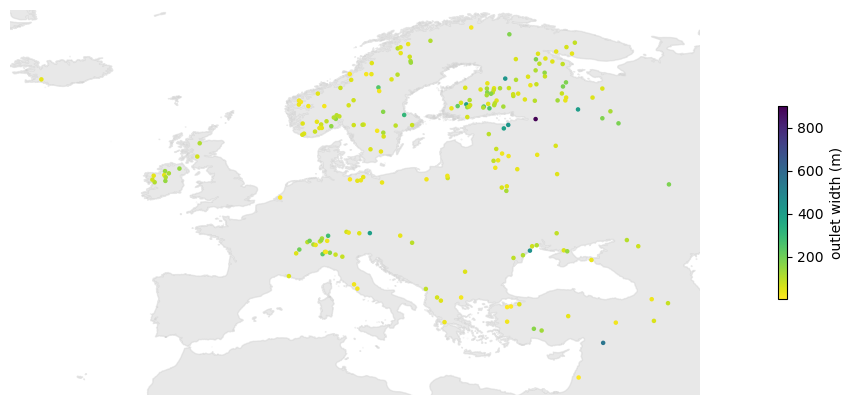

In [27]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=alpha.EFAS6,
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='outlet width (m)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'outlet_width_map.jpg', dpi=300, bbox_inches='tight')

# add values to EFAS6
efas6.loc[alpha.index, ['WIDTH_M', 'WIDTH_SRC']] = alpha[['EFAS6', 'SOURCE']].values

### Average inflow

In [28]:
dis_avg = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'NAT_FLOW', 'GLWD', 'HYLAK', 'EFAS6', 'SOURCE'], dtype=float)
dis_avg.SOURCE = alpha.SOURCE.astype(str)

# EFAS5
idx = efas6[efas6.LAK_ID.notnull()].LAK_ID
dis_avg.loc[idx.index, 'EFAS5'] = efas5.loc[idx.values, 'avinflow'].values

# EFAS5 naturalised long-term run 
dis = xr.open_dataset(PATH_EFAS6 / 'lakes' / 'ncextract' / 'dis_215.nc')['dis']
dis = dis.sel(time=slice('1993-01-02', None))
dis.close()
dis_avg['NAT_FLOW'] = dis.mean('time').to_pandas()

# GLWD
idx = efas6[efas6.GLWD_ID.notnull()].GLWD_ID
dis_avg.loc[idx.index, 'GLWD'] = glwd.loc[idx.values, 'INFLOW_CMS'].values

# HydroLakes
idx = efas6[efas6.HYLAK_ID.isin(hylak.index)].HYLAK_ID
dis_avg.loc[idx.index, 'HYLAK'] = hylak.loc[idx.values, 'Dis_avg'].values

#### Comparison

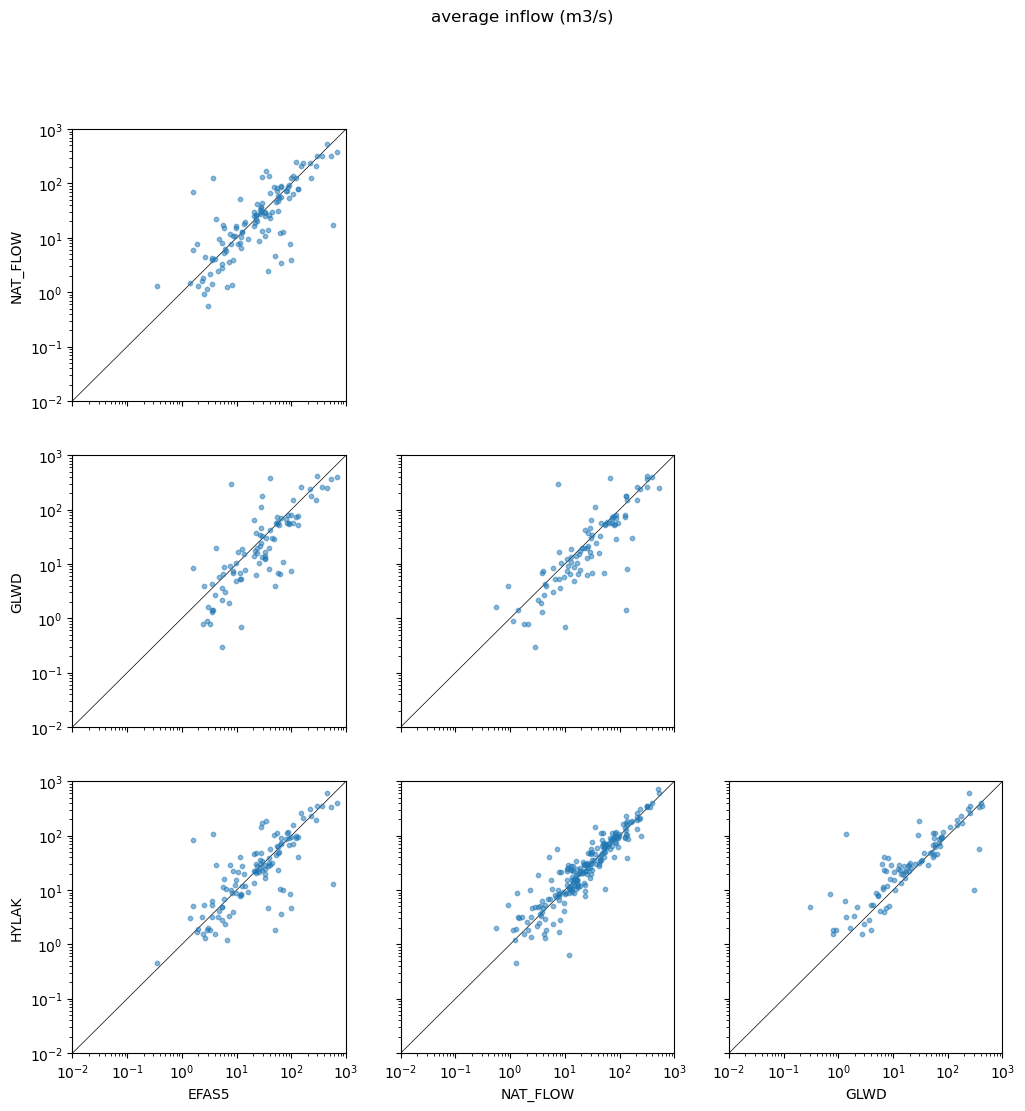

In [29]:
compare_attributes(
    dis_avg[['EFAS5', 'NAT_FLOW', 'GLWD', 'HYLAK']],
    thr=0,
    vmin=0.01,
    vmax=1000,
    title='average inflow (m3/s)'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select value

I will select in all cases the value from the EFAS5 naturalised run.

In [30]:
dis_avg.EFAS6 = dis_avg.NAT_FLOW
dis_avg.SOURCE = 'EFAS5_natflow' 

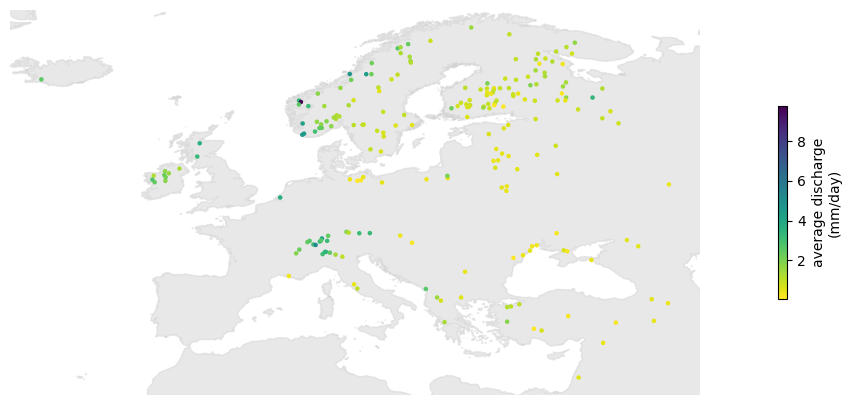

In [31]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    efas6.geometry.x,
    efas6.geometry.y,
    c=dis_avg.EFAS6 / efas6.CATCH_SKM * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='average discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_map.jpg', dpi=300, bbox_inches='tight')

In [32]:
# add values to EFAS6
efas6.loc[alpha.index, ['DISAVG_CMS', 'DIS_SRC']] = dis_avg[['EFAS6', 'SOURCE']].values

## Export
### Excel file
#### Lakes

In [33]:
lakes = efas6.copy()

# add coordinates in the LISFLOOD grid
lakes['LisfloodX'] = lakes.geometry.x
lakes['LisfloodY'] = lakes.geometry.y

# add info from HydroLakes
hylak_ids = lakes.HYLAK_ID.dropna()
hylak_cols = {'Lake_name': 'LAKE_NAME', 
              'Country': 'COUNTRY',
              'Pour_long': 'LONG_DD',
              'Pour_lat': 'LAT_DD'}
lakes.loc[hylak_ids.index, hylak_cols.values()] = hylak.loc[hylak_ids.values, hylak_cols].rename(columns=hylak_cols).values

# reorder columns
cols = ['LAK_ID', 'GDW_ID', 'RES_ID', 'GLWD_ID', 'HYLAK_ID', 'GRAND_ID', 'ICOLD_ID',
        'LAKE_NAME', 'COUNTRY', 
        'LONG_DD', 'LAT_DD', 'LisfloodX', 'LisfloodY', 
        'CATCH_SKM', 'CATCH_SRC', 'AREA_SKM', 'AREA_SRC', 'WIDTH_M', 'WIDTH_SRC', 'DISAVG_CMS', 'DIS_SRC']
lakes = lakes[lakes.columns.intersection(cols)]

#### Reservoirs as lakes

In [34]:
# compute outlet width of reservoirs
reservoirs['WIDTH_M'] = width_from_area(reservoirs.CATCH_SKM, c=params[0])
reservoirs['WIDTH_SRC'] = 'EXP'

# rename and reorder columns
reservoirs.rename(columns={'RES_NAME': 'LAKE_NAME'}, inplace=True, errors='ignore')
reservoirs = reservoirs[reservoirs.columns.intersection(cols)]

#### Combination

In [36]:
# merge
lakes_reservoirs = pd.concat((lakes, reservoirs), axis=0)[cols]
lakes_reservoirs.sort_values(['LAK_ID', 'RES_ID'], inplace=True)

# reset index
# reservoirs['FID'] = np.arange(1, reservoirs.shape[0] + 1)
# reservoirs.loc[reservoirs.ResID > 5000, 'FID'] = reservoirs.loc[reservoirs.ResID > 5000, 'ResID']
idx = []
i = 1000
for lak_id in lakes_reservoirs.LAK_ID.values:
    if pd.isna(lak_id):
        i += 1
        idx.append(i)
    else:
        idx.append(lak_id)
lakes_reservoirs['FID'] = idx
lakes_reservoirs.set_index('FID', drop=True, inplace=True)
lakes_reservoirs.sort_index(axis=0, inplace=True)

# export
xls_file = PATH_OUT / 'efas6_lakes_{0}.xlsx'.format(datetime.now().strftime('%Y%m%d'))
lakes_reservoirs.to_excel(xls_file, float_format='%.4f')
print(f'Lake Excel table saved in: {xls_file}')

Lake Excel table saved in: Z:\nahaUsers\casadje\EFASv6\lakes\tables\efas6_lakes_20250304.xlsx


### TXT tables

In [37]:
# table lake area
(lakes_reservoirs.AREA_SKM * 1e6).to_csv(
    PATH_OUT / 'lakes_efas6_area_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None,
    float_format='%.0f'
)

# table average inflow
lakes_reservoirs.DISAVG_CMS.round(1).to_csv(
    PATH_OUT / 'lakes_efas6_avg_inflow_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None
)

# table alpha parameter
lakes_reservoirs.WIDTH_M.round(1).to_csv(
    PATH_OUT / 'lakes_efas6_alpha_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None
)

### NetCDF map

In [57]:
# load map from GloFAS4
mapa = rxr.open_rasterio(PATH_EFAS5 / 'static_maps' / 'lakes_European_01min.nc')#.squeeze(dim='band').astype(int)
mapa.close()

# remove all lakes
mapa[:,:] = 0

# assign IDs of lakes in GloFAS5
for ID, row in tqdm(lakes_reservoirs.iterrows(), total=len(lakes_reservoirs)):
    pixel = mapa.sel({'x': row.LisfloodX, 'y': row.LisfloodY}, method='nearest')
    mapa.loc[{'x': pixel.x.item(), 'y': pixel.y.item()}] = ID

# modify attributes
mapa.attrs['contributors'] = 'Juliana Disperati <juliana.disperati@ext.ec.europa.eu>'
mapa.attrs['creator'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu>'
mapa.attrs['creator_name'] = 'casadje'
mapa.attrs['history'] = ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y")))
mapa.attrs['history_of_appended_files'] = ''
mapa.attrs['institution'] = 'Joint Research Centre - European Commission'
mapa.attrs['references'] = 'https://www.hydrosheds.org/products/hydrolakes'

# Ensure latitude (y) is sorted from highest to lowest
mapa = mapa.sortby('y', ascending=False)

# define coordinate reference system
mapa = mapa.rio.write_crs('EPSG:4326')

# export NetCDF map
mapa.rio.to_raster(PATH_OUT / 'lakes_efas6_01min_{0}.nc'.format(datetime.now().strftime('%Y%m%d')))

  0%|          | 0/397 [00:00<?, ?it/s]

In [60]:
# load map from GloFAS4
mapa = xr.open_dataarray(PATH_EFAS5 / 'static_maps' / 'lakes_European_01min.nc')#.squeeze(dim='band').astype(int)
mapa.close()

# remove all lakes
mapa[:,:] = 0

# assign IDs of lakes in GloFAS5
for ID, row in tqdm(lakes_reservoirs.iterrows(), total=len(lakes_reservoirs)):
    pixel = mapa.sel({'lon': row.LisfloodX, 'lat': row.LisfloodY}, method='nearest')
    mapa.loc[{'lon': pixel.lon.item(), 'lat': pixel.lat.item()}] = ID

# modify attributes
mapa.attrs['contributors'] = 'Juliana Disperati <juliana.disperati@ext.ec.europa.eu>'
mapa.attrs['creator'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu>'
mapa.attrs['creator_name'] = 'casadje'
mapa.attrs['history'] = ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y")))
mapa.attrs['history_of_appended_files'] = ''
mapa.attrs['institution'] = 'Joint Research Centre - European Commission'
mapa.attrs['references'] = 'https://www.hydrosheds.org/products/hydrolakes'

# Ensure latitude (y) is sorted from highest to lowest
mapa = mapa.sortby('lat', ascending=False)

# # define coordinate reference system
# mapa = mapa.rio.write_crs('EPSG:4326')

# export NetCDF map
mapa.to_netcdf(PATH_OUT / 'lakes_efas6_01min_{0}.nc'.format(datetime.now().strftime('%Y%m%d')))

  0%|          | 0/397 [00:00<?, ?it/s]

In [59]:
mapa.lat.data

array([72.24166667, 72.225     , 72.20833333, ..., 22.79166667,
       22.775     , 22.75833333])